# Setup

## Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from cycler import cycle

import qutip as qp

import pandas as pd
import scqubits as scq

import xarray as xr


import scipy.linalg as la
import scipy.optimize as opt
import scipy.fft as fft

import colormaps as cmaps
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import itertools as itert

import IPython.display

import sys

import copy

import pickle

import json

import pathlib

import os

import inspect

from datetime import datetime


path_to_package = str(pathlib.Path(os.getcwd()).parents[0])+'/Main Package/'
print(path_to_package)
sys.path.insert(0,path_to_package)

main_path = str(pathlib.Path(os.getcwd()).parents[0])+'/'

import importlib

import Transmon_Cavity_Model as TCM

/local/gr400/Git Repositories/Research-SpinChainEntropy/CavityModeDriveSimulations/Main Package/


In [2]:
scq.settings.OVERLAP_THRESHOLD = 0.25

## Reload Model

In [3]:
importlib.reload(TCM)

<module 'Transmon_Cavity_Model' from '/local/gr400/Git Repositories/Research-SpinChainEntropy/CavityModeDriveSimulations/Main Package/Transmon_Cavity_Model.py'>

In [5]:
model_name = 'Mode_3'
save_path = 'Model Saves/'+model_name
save_path = main_path+save_path + '/'

Mode3 = TCM.LoadModel(save_path+model_name+'.json')

model_name = 'Mode_3_And_5'
save_path = 'Model Saves/'+model_name
save_path = main_path+save_path + '/'

Mode35 = TCM.LoadModel(save_path+model_name+'.json')


In [6]:
print(f'E_C: {Mode3.E_C}')
print(f'E_J: {Mode3.E_J}')
print(f'g: {Mode3.g}')
print(f'E_osc: {Mode3.E_osc}')
print(f'resonator_truncated_dim: {Mode3.resonator_truncated_dim}')
print(f'transmon_truncated_dim: {Mode3.transmon_truncated_dim}')
print(f'transmon_ncut: {Mode3.transmon_ncut}')

E_C: 0.10283303447280807
E_J: 26.96976142643705
g: [0.026184375000000013]
E_osc: 6.2280871213
resonator_truncated_dim: [10]
transmon_truncated_dim: 10
transmon_ncut: 60


In [7]:
print(f'E_C: {Mode35.E_C}')
print(f'E_J: {Mode35.E_J}')
print(f'g: {Mode35.g}')
print(f'E_osc: {Mode35.E_osc}')
print(f'resonator_truncated_dim: {Mode35.resonator_truncated_dim}')
print(f'transmon_truncated_dim: {Mode35.transmon_truncated_dim}')
print(f'transmon_ncut: {Mode35.transmon_ncut}')

E_C: 0.10283303447280807
E_J: 26.96976142643705
g: [0.026184375000000013, 0.03020625000000001]
E_osc: [6.2280871213, 6.72062927579]
resonator_truncated_dim: [6, 6]
transmon_truncated_dim: 10
transmon_ncut: 60


# Duplicating Julia Procedure (ONLY WORKS FOR 1 MODE)

## The class

In [10]:
class Transmon_Resonator:
    
    def __init__(self, EC, EJ, gs, omegas, Nt=10, Nt_trunc=60, Nrs=[10], Nrs_trunc=15, ng=0, sparse_eigs_factor = 5):
        self.EC = EC
        self.EJ = EJ
        self.gs = gs
        self.omegas = omegas
        self.Nt = Nt
        self.Nrs = Nrs
        self.Nt_trunc = Nt_trunc
        self.Nrs_trunc = [Nrs_trunc]*len(Nrs)
        self.ng = ng
        self.sparse_eigs_factor = sparse_eigs_factor

    
    def Initializer(self):

        # Building Non-Truncated Transmon 
        # ==================================================================================
        print("Building Non-Truncated Transmon")
        Trans_Dim_Full = 2*self.Nt_trunc+1
        It_full = qp.qeye(Trans_Dim_Full)
        
        jump = qp.tunneling(Trans_Dim_Full, 1)

        nt_full = qp.charge(self.Nt_trunc)

        Ht_full = 4*self.EC*(self.ng*It_full-nt_full)**2-0.5*self.EJ*jump

        # Building Non-Truncated Resonator Hamiltonians
        # ==================================================================================
        print("Building Non-Truncated Resonator Hamiltonians")
        Irs_full = []
        ars_full = []
        Hrs_full = []

        for i in range(len(self.Nrs_trunc)):
            Nr = self.Nrs_trunc[i]
            ar = qp.create(Nr+1)
            Irs_full.append(qp.qeye(Nr+1))
            ars_full.append(ar)
            Hrs_full.append(self.omegas[i]*ar.dag()*ar)
        
        Hr_full = qp.tensor(Irs_full)*0
        for i in range(len(self.Nrs_trunc)):
            ops = copy.copy(Irs_full)
            ops[i] = Hrs_full[i]

            Hr_full+= qp.tensor(ops)

        # Building Non-Truncated Interaction Hamiltonian
        # ==================================================================================
        print("Building Non-Truncated Interaction Hamiltonian")
        Hnon_int_full = qp.tensor([Ht_full]+Irs_full)+qp.tensor(It_full, Hr_full)

        Hint_full = 0*copy.copy(Hnon_int_full)
    
        for i in range(len(self.Nrs_trunc)):
            ops = copy.copy(Irs_full)
            ops[i] = ars_full[i]+ars_full[i].dag()

            Hint_full += self.gs[i]*qp.tensor([nt_full]+ops)
        
        H_full = Hnon_int_full + Hint_full
    
        # Labeling Dressed States
        # ==================================================================================
        print("Labeling Dressed States")
        dressed_eigsys = (0.5*(H_full+H_full.dag())).eigenstates()#sparse = True, eigvals = self.sparse_eigs_factor*(self.Nt*prod(self.Nrs)))
        bare_transmon_eigsys = Ht_full.eigenstates()
        bare_resonator_eigsys_list = []
        for i in range(len(self.Nrs)):
            bare_resonator_eigsys_list.append(Hrs_full[i].eigenstates())
        
        overlap_dict = {}
        res_iter_list = []
        for Nr_i in self.Nrs:
            res_iter_list.append(np.arange(0,Nr_i+1))
        
        states_to_keep_iter = itert.product(np.arange(0,self.Nt+1), *res_iter_list)

        for state in states_to_keep_iter:
            overlap_dict[state] = np.zeros(len(dressed_eigsys[0]))
            
            psi_bare_s = []
            psi_bare_s.append(bare_transmon_eigsys[1][state[0]])
            psi_bare_rs = []
            for i in range(len(self.Nrs)):
                psi_bare_s.append(bare_resonator_eigsys_list[i][1][state[i+1]])
            
            psi_bare = qp.tensor(psi_bare_s)

            for i in range(len(dressed_eigsys[0])):
                psi_dressed = dressed_eigsys[1][i]
                overlap_dict[state][i] = abs((psi_bare.dag()*psi_dressed).tr())**2
        
        dressed_states_dict_full = {}
        dressed_energy_dict_full = {}

        states_to_keep_iter = itert.product(np.arange(0,self.Nt+1), *res_iter_list)
        for state in states_to_keep_iter:
            state_idx = np.argmax(overlap_dict[state])
            dressed_states_dict_full[state] = dressed_eigsys[1][state_idx]
            dressed_energy_dict_full[state] = dressed_eigsys[0][state_idx]

        # Labeling Dressed States
        # ==================================================================================
        print("Labeling Dressed States")
        dressed_states_dict_trunc = {}

        n = qp.tensor([nt_full]+Irs_full)

        Pi = np.zeros((len(dressed_states_dict_full), H_full.shape[0]), dtype = complex)
        for i, key in enumerate(dressed_states_dict_full):
            state = dressed_states_dict_full[key]
            Pi[i,:] = state.data.todense().flatten()
        
        n_array = Pi*n.data.todense()*np.conj(Pi.T)
        H_array = Pi*H_full.data.todense()*np.conj(Pi.T)

        return(dressed_energy_dict_full)




## Testing

In [43]:
EC = 0.10283303447280807
EJ = 26.96976142643705
gs = [0.026184375000000013]
omegas = [6.22808712131]
Nt = 10
Nrs = [10]

test_class = Transmon_Resonator(EC = Mode3.E_C, EJ = Mode3.E_J, gs = Mode3.g, omegas = [Mode3.E_osc], Nt = Nt, Nrs = Nrs, Nt_trunc = 40, Nrs_trunc = 10)

In [44]:
dressed_energies = test_class.Initializer()

Building Non-Truncated Transmon
Building Non-Truncated Resonator Hamiltonians
Building Non-Truncated Interaction Hamiltonian
Labeling Dressed States
Labeling Dressed States


In [45]:
dressed_energies[(0,0)]

-24.64088985959997

In [46]:
test = itert.product(["1", "2"], ["a", "b"])
for i in test:
    print(f"i: {i}")#, test: {list(test)}")
print(list(test))

i: ('1', 'a')
i: ('1', 'b')
i: ('2', 'a')
i: ('2', 'b')
[]


In [303]:
def fib(N):
    x1 = 1
    x2 = 1
    for i in range(N):
        temp = x1
        x1 = x1+x2
        x2 = temp
        yield x1
        

# Comparing With Julia

## Making Data

In [8]:
model3 = TCM.Transmon_Cavity_Model(E_C = Mode3.E_C, E_J = Mode3.E_J, g = Mode3.g, E_osc = Mode3.E_osc, resonator_truncated_dim=10, transmon_truncated_dim=10, transmon_ncut = 40)
model35 = TCM.Transmon_Cavity_Model(E_C = Mode35.E_C, E_J = Mode35.E_J, g = Mode35.g, E_osc = Mode35.E_osc, resonator_truncated_dim=6, transmon_truncated_dim=10, transmon_ncut = 40)

In [18]:
model3_class = Transmon_Resonator(EC = Mode3.E_C, EJ = Mode3.E_J, gs = Mode3.g, omegas = [Mode3.E_osc], Nt = 10, Nrs = [10], Nt_trunc = 40, Nrs_trunc = 10)
dressed_energies_3 = model3_class.Initializer()

Building Non-Truncated Transmon
Building Non-Truncated Resonator Hamiltonians
Building Non-Truncated Interaction Hamiltonian
Labeling Dressed States
Labeling Dressed States


## Loading Data

In [20]:
imported_dat = pd.read_csv("comparison_3.csv")
comparison_table_mode3 = xr.DataArray(dims = ["State", "Implementation"], coords = [imported_dat['first'].values, ["Julia", "scqubits", "My Python"]])
for str_state in comparison_table_mode3.coords['State'].values:
    state = eval(str_state)
    comparison_table_mode3.loc[{"State":str_state, "Implementation":"scqubits"}] = model3.hilbertspace.energy_by_bare_index(state)
    comparison_table_mode3.loc[{"State":str_state, "Implementation":"My Python"}] = dressed_energies_3[state]
    idx = imported_dat.index[imported_dat['first'] == str_state].tolist()[0]
    #comparison_table.loc[{"State":str_state, "Implementation":"Julia"}] = test2.hilbertspace.energy_by_bare_index(state)#imported_dat['second'][idx]
    comparison_table_mode3.loc[{"State":str_state, "Implementation":"Julia"}] = imported_dat['second'][idx]



imported_dat = pd.read_csv("comparison_35.csv")
comparison_table_mode35 = xr.DataArray(dims = ["State", "Implementation"], coords = [imported_dat['first'].values, ["Julia", "scqubits", "My Python"]])
for str_state in comparison_table_mode35.coords['State'].values:
    state = eval(str_state)
    comparison_table_mode35.loc[{"State":str_state, "Implementation":"scqubits"}] = model35.hilbertspace.energy_by_bare_index(state)
    #comparison_table_mode3.loc[{"State":str_state, "Implementation":"My Python"}] = dressed_energies[state]
    idx = imported_dat.index[imported_dat['first'] == str_state].tolist()[0]
    #comparison_table.loc[{"State":str_state, "Implementation":"Julia"}] = test2.hilbertspace.energy_by_bare_index(state)#imported_dat['second'][idx]
    comparison_table_mode35.loc[{"State":str_state, "Implementation":"Julia"}] = imported_dat['second'][idx]

## Looking At Energies

### Plotting Difference

### Just Mode 3

Text(0.5, 1.0, 'Comparing Energies, Differences! (Mode 3)')

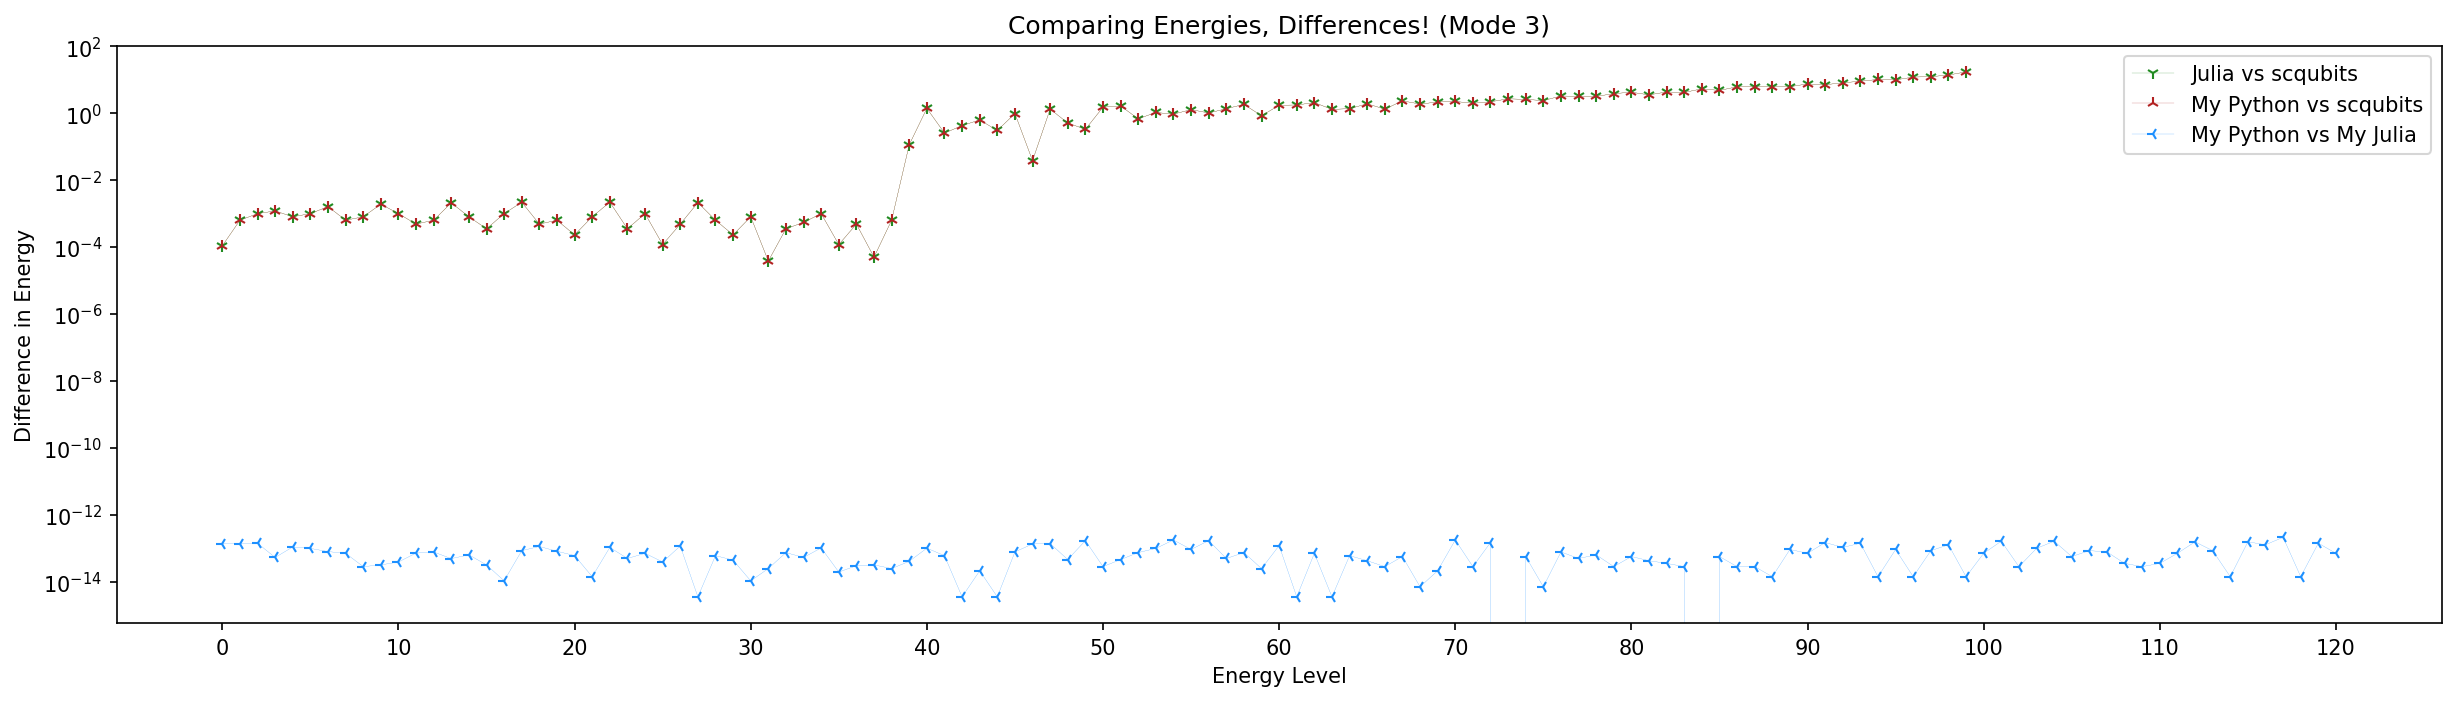

In [22]:
plt.figure(figsize = (20, 5), dpi = 150)

y_scqubits = comparison_table_mode3.loc[{"Implementation":"scqubits"}].values
y_python = comparison_table_mode3.loc[{"Implementation":"My Python"}].values
y_julia = comparison_table_mode3.loc[{"Implementation":"Julia"}].values
x_labels = comparison_table_mode3.coords["State"].values

y_python = np.sort(y_python)
y_julia = np.sort(y_julia)
y_scqubits = np.sort(y_scqubits)

x = np.arange(0, len(y_scqubits))

plt.plot(x, np.abs((y_scqubits - y_julia)), color = 'forestgreen', marker = '1', lw = 0.1, label = "Julia vs scqubits")
plt.plot(x, np.abs((y_python - y_scqubits)), color = 'firebrick', marker = '2', lw = 0.1, label = "My Python vs scqubits")
plt.plot(x, np.abs((y_python - y_julia)), color = 'dodgerblue', marker = '3', lw = 0.1, label = "My Python vs My Julia")

skip = 5

plt.xticks(x[::10])

plt.yscale('log')
plt.legend()

plt.ylabel("Difference in Energy")
plt.xlabel("Energy Level")
plt.title("Comparing Energies, Differences! (Mode 3)")


### Mode 3 and 5

Text(0.5, 1.0, 'Comparing Energies, Differences! (Mode 3 and 5)')

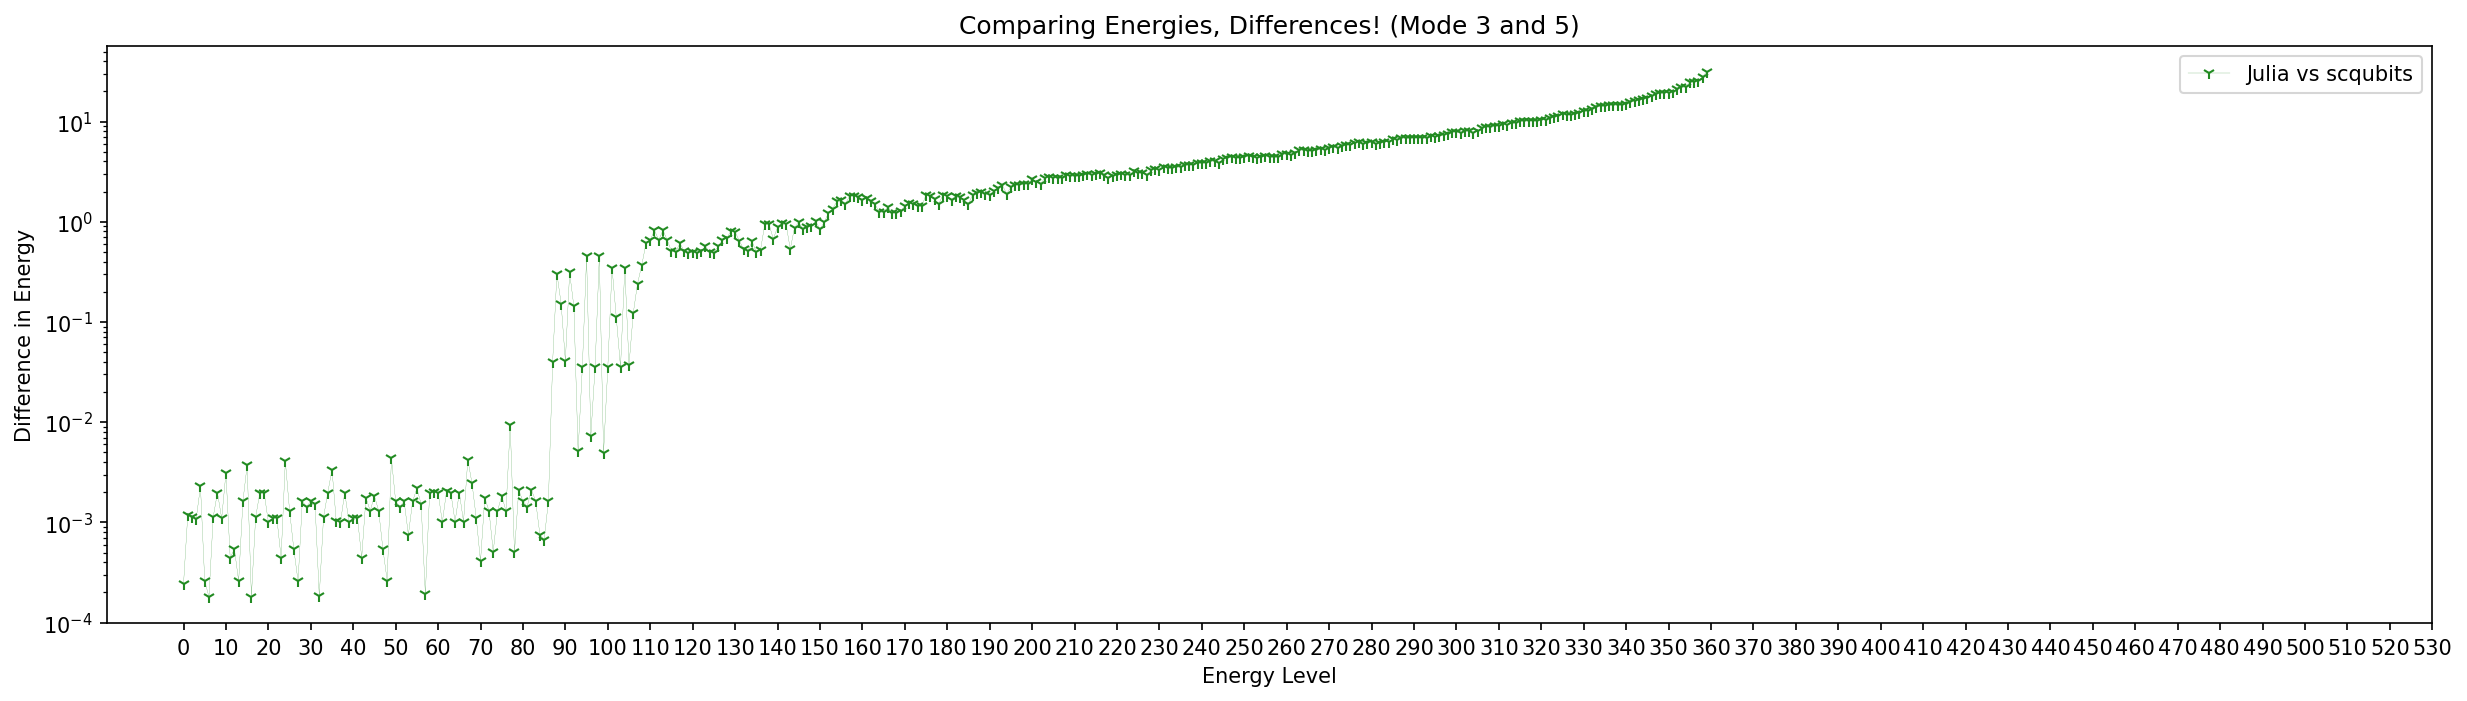

In [24]:
plt.figure(figsize = (20, 5), dpi = 150)

y_scqubits = comparison_table_mode35.loc[{"Implementation":"scqubits"}].values
#y_python = comparison_table_mode3.loc[{"Implementation":"My Python"}].values
y_julia = comparison_table_mode35.loc[{"Implementation":"Julia"}].values
x_labels = comparison_table_mode3.coords["State"].values

#y_python = np.sort(y_python)
y_julia = np.sort(y_julia)
y_scqubits = np.sort(y_scqubits)

x = np.arange(0, len(y_scqubits))

plt.plot(x, np.abs((y_scqubits - y_julia)), color = 'forestgreen', marker = '1', lw = 0.1, label = "Julia vs scqubits")
#plt.plot(x, np.abs((y_python - y_scqubits)), color = 'firebrick', marker = '2', lw = 0.1, label = "My Python vs scqubits")
#plt.plot(x, np.abs((y_python - y_julia)), color = 'dodgerblue', marker = '3', lw = 0.1, label = "My Python vs My Julia")

skip = 5

plt.xticks(x[::10])

plt.yscale('log')
plt.legend()

plt.ylabel("Difference in Energy")
plt.xlabel("Energy Level")
plt.title("Comparing Energies, Differences! (Mode 3 and 5)")
